# Unit 5 - Financial Planning

In [49]:
# Initial imports
import os
import requests
import pandas as pd
import datetime as dt
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation


### added to visualize the data and to get extract its data
import json
### added to ignore warnings
import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv('alpaca.env')

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
shares_data = {
    "shares": [1.2, 5.3]
}

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [5]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url).json()
btc_price = btc_response_data['data']['1']['quotes']['USD']['price']
###print(json.dumps(btc_response_data, indent=4))
print(f'The current BTC price is {btc_price:0.2f}')

# Fetch current ETH price
eth_response_data = requests.get(eth_url).json()
eth_price = eth_response_data['data']['1027']['quotes']['USD']['price']
###print(json.dumps(eth_response_data, indent=4))
print(f'The current ETH price is {eth_price:0.2f}')

# Compute current value of my crpto
my_btc = (shares_data['shares'][0])
my_btc_value = my_btc * btc_price

my_eth = (shares_data['shares'][1])
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current BTC price is 27144.00
The current ETH price is 1556.47
The current value of your 1.2 BTC is $32572.80
The current value of your 5.3 ETH is $8249.29


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [45]:
# Format current date as ISO format
### Can't use current day/date!
###using homework output dates
###homework used a different format of 2020-05-01 00:00:00-04:00
hw_start_date = pd.Timestamp("2020-05-01", tz='America/New_York').isoformat()
hw_end_date = pd.Timestamp("2020-05-07", tz='America/New_York').isoformat()


In [9]:
# Set the tickers
tickers = ["AGG", "SPY"]

In [10]:
# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

In [52]:
# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = hw_start_date,
    end = hw_end_date
).df

##dropped extra columns
df_portfolio.drop(columns = ['vwap', 'trade_count'], inplace=True)
##df_portfolio.index = df_portfolio.index.date
###Display sample data
df_portfolio.head(5)

,close,high,low,open,volume,symbol
2020-05-01,116.87,117.0998,116.6775,116.97,6331654,AGG
2020-05-04,116.97,117.0900,116.8700,116.89,3803239,AGG
2020-05-05,116.88,116.9700,116.8100,116.96,5593693,AGG
2020-05-06,116.41,116.7100,116.3000,116.44,7832788,AGG
2020-05-07,116.77,116.7700,116.4200,116.61,3914327,AGG


In [12]:
# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio["symbol"]=="AGG"].drop("symbol", axis=1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

### if I wanted to drop the columns without dropping it from the entire df_portfolio dataframe and do it afterwards
#AGG.drop(columns = ['vwap', 'trade_count'], inplace=True)
#SPY.drop(columns = ['vwap', 'trade_count'], inplace=True)

###Reorder columns to match homework output
AGG = AGG[['open', 'high', 'low', 'close', 'volume']]
SPY = SPY[['open', 'high', 'low', 'close', 'volume']]

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY],axis=1, keys=['AGG', 'SPY'])

# Preview DataFrame
df_portfolio.head(5)

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2020-05-01 04:00:00+00:00  116.97  117.0998  116.6775  116.87  6331654   
2020-05-04 04:00:00+00:00  116.89  117.0900  116.8700  116.97  3803239   
2020-05-05 04:00:00+00:00  116.96  116.9700  116.8100  116.88  5593693   
2020-05-06 04:00:00+00:00  116.44  116.7100  116.3000  116.41  7832788   
2020-05-07 04:00:00+00:00  116.61  116.7700  116.4200  116.77  3914327   

                              SPY                                         
                             open      high       low   close     volume  
timestamp                                                                 
2020-05-01 04:00:00+00:00  285.31  290.6572  281.5200  282.83  127002350  
2020-05-04 04:00:00+00:00  280.74  283.9000  279.1300  283.59   81813464  
2020-05-05 04:00:00+00:00  286.64  289.2500  283.7134  286.15   80363726  
2020-05-06 04:00:00+00:00  288.04  288.4600  283.7800  284.34   74268760  
2020-05-07 04:00:00+00:00  287.75  289.7800  287.1300  287.70   75995625

In [13]:
# Pick AGG and SPY close prices
###the homework output selected the first date 2020-05-01
agg_close_price = float(df_portfolio.iloc[0][0])

###deprecated python function listed below
#agg_close_price = float(df_portfolio['AGG']['close']['2020-05-01'])

spy_close_price = float(df_portfolio.iloc[0][7])

###deprecated python function listed below
#spy_close_price = float(df_portfolio['SPY']['close']['2020-05-01'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $116.97
Current SPY closing price: $281.52


In [14]:
# Compute the current value of shares
my_spy_value = agg_close_price * my_agg
my_agg_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $23394.00
The current value of your 200 AGG shares is $14076.00


### Savings Health Analysis

In [15]:
# Set monthly household income
monthly_income = 9166.67

# Consolidate financial assets data
### is there a way to label crpyto row without having to change the index manually later?
crypto_data = {
    "amount": 106407.569394
}

shares_data = {
    "amount": 37516.500000
}

# Create savings DataFrame
df_savings = pd.DataFrame([crypto_data, shares_data],index=["crypto",'shares'])
#df_savings = pd.DataFrame([crypto_data, shares_data])
#df_savings.index = ['crypto', 'shares']

# Display savings DataFrame
display(df_savings)

,amount
crypto,106407.569394
shares,37516.500000


In [16]:
##Alternative way to "hard" set row names

###renaming columns to appropriate names
##df_savings.index = ['crypto', 'shares']

#### Display savings DataFrame
display(df_savings)

,amount
crypto,106407.569394
shares,37516.500000


<Axes: title={'center': 'Composition of Personal Savings'}, ylabel='amount'>

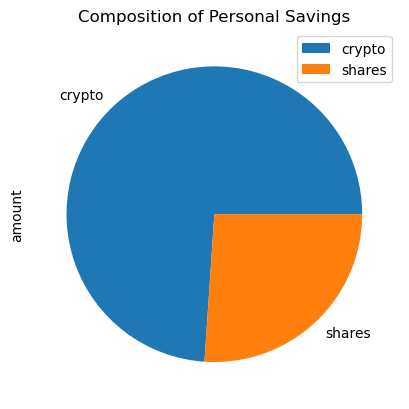

In [17]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings")

In [18]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
print(f'Your ideal emergency fund is in the ammount of ${emergency_fund:0.2f} USD.')

total_portfolio = df_savings.sum()
print(f'Your portfolio ammount is ${float(total_portfolio):0.2f} USD.')

###alternatively
total_portfolio = float(df_savings['amount']['shares']) + float(df_savings['amount']['crypto'])

# Validate saving health
if total_portfolio > emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
elif total_portfolio < emergency_fund:
     print("Oh no! You do not have enough money in your emergency fund!")
else:
    pass

Your ideal emergency fund is in the ammount of $27500.01 USD.
Your portfolio ammount is $143924.07 USD.
Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [19]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
###changed start_date from 2016-05-01 to 2017-05-10 to match the hw5 output
start_date = pd.Timestamp('2017-05-10', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [20]:
# Get 5 years' worth of historical data for SPY and AGG
df_ticker = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_ticker[df_ticker['symbol']=="AGG"].drop('symbol', axis=1)
SPY = df_ticker[df_ticker['symbol']=="SPY"].drop('symbol', axis=1)

###dropped extra columns
AGG.drop(columns = ['vwap', 'trade_count'], inplace=True)
SPY.drop(columns = ['vwap', 'trade_count'], inplace=True)

###Reorder coluimns to have close as last column
AGG = AGG[['volume', 'open', 'low', 'high', 'close']]
SPY = SPY[['volume', 'open', 'low', 'high', 'close']]

# Concatenate the ticker DataFrames
df_ticker = pd.concat([AGG, SPY], axis=1, keys=["AGG","SPY"])
df_ticker.sort_values(['timestamp'], ascending=True,inplace=True)

# Display sample data
###df_stock_data.head()
df_ticker.head()

AGG                                      \
                            volume    open       low     high    close   
timestamp                                                                
2017-05-10 04:00:00+00:00  1665529  108.60  108.4400  108.660  108.530   
2017-05-11 04:00:00+00:00  2381236  108.35  108.3435  108.540  108.520   
2017-05-12 04:00:00+00:00  1400136  108.81  108.7800  108.940  108.915   
2017-05-15 04:00:00+00:00  1814216  108.85  108.8200  108.940  108.880   
2017-05-16 04:00:00+00:00  2111519  108.88  108.8800  109.101  109.020   

                                SPY                                      
                             volume    open     low      high     close  
timestamp                                                                
2017-05-10 04:00:00+00:00  55725130  239.39  239.15  239.8700  239.8600  
2017-05-11 04:00:00+00:00  63504282  239.35  238.13  239.5700  239.4592  
2017-05-12 04:00:00+00:00  55661293  239.09  238.67  239.4273  239.0500  
2017-05-15 04:00:00+00:00  63907987  239.47  239.45  240.4400  240.2297  
2017-05-16 04:00:00+00:00  53339787  240.64  239.63  240.6700  240.0900

In [21]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
###weight of .60% stocks in SPY and .40% bonds in AGG
MC_30year = MCSimulation(
    portfolio_data=df_ticker,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [22]:
# Printing the simulation input data
MC_30year.portfolio_data.head()

AGG                                      \
                            volume    open       low     high    close   
timestamp                                                                
2017-05-10 04:00:00+00:00  1665529  108.60  108.4400  108.660  108.530   
2017-05-11 04:00:00+00:00  2381236  108.35  108.3435  108.540  108.520   
2017-05-12 04:00:00+00:00  1400136  108.81  108.7800  108.940  108.915   
2017-05-15 04:00:00+00:00  1814216  108.85  108.8200  108.940  108.880   
2017-05-16 04:00:00+00:00  2111519  108.88  108.8800  109.101  109.020   

                                             SPY                            \
                          daily_return    volume    open     low      high   
timestamp                                                                    
2017-05-10 04:00:00+00:00          NaN  55725130  239.39  239.15  239.8700   
2017-05-11 04:00:00+00:00    -0.000092  63504282  239.35  238.13  239.5700   
2017-05-12 04:00:00+00:00     0.003640  55661293  239.09  238.67  239.4273   
2017-05-15 04:00:00+00:00    -0.000321  63907987  239.47  239.45  240.4400   
2017-05-16 04:00:00+00:00     0.001286  53339787  240.64  239.63  240.6700   

                                                  
                              close daily_return  
timestamp                                         
2017-05-10 04:00:00+00:00  239.8600          NaN  
2017-05-11 04:00:00+00:00  239.4592    -0.001671  
2017-05-12 04:00:00+00:00  239.0500    -0.001709  
2017-05-15 04:00:00+00:00  240.2297     0.004935  
2017-05-16 04:00:00+00:00  240.0900    -0.000582

In [23]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 340.
Running Monte Carlo simulation number 350.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 360.
Running Monte Carlo simulation number 370.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 400.
Running Monte Carlo simulation number 410.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 440.
Running Monte Carlo simulation number 450.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003142,0.996655,0.990191,0.999475,0.993172,1.001297,1.003239,1.006956,1.003739,1.000356,...,1.006574,1.006943,1.012186,1.008902,1.006419,0.993648,0.996801,1.008949,0.998522,0.999138
2,1.010718,0.989100,0.984400,1.002503,0.998173,0.993789,1.002061,0.998611,1.005781,0.992643,...,1.003508,1.005925,1.012844,1.009365,0.997775,0.982307,0.991084,1.013198,1.001094,0.992684
3,1.017532,0.990478,0.981679,1.002518,0.990405,0.986685,0.996391,0.992705,1.003898,0.992648,...,1.001319,1.003053,1.012544,1.015518,0.995807,0.973801,0.991579,1.012334,0.997478,0.986261
4,1.015150,0.987839,0.984256,0.993456,0.992491,0.992662,0.997154,0.997993,1.009981,0.989363,...,1.001391,1.001139,1.009399,1.022642,1.003038,0.973437,0.998328,1.007289,1.010872,0.977435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.044561,1.448667,1.096191,1.007453,1.426121,1.149318,1.268142,1.004350,1.378832,1.322662,...,1.292453,1.290365,1.016386,1.569261,2.075668,1.296581,1.277361,2.203220,1.398208,1.106093
1257,2.042180,1.454694,1.090727,1.003700,1.426765,1.151575,1.275344,1.011542,1.386475,1.324218,...,1.302002,1.293804,1.017348,1.566868,2.083997,1.291740,1.280131,2.196524,1.404254,1.111182
1258,2.039082,1.466575,1.092033,1.005063,1.428467,1.148293,1.280364,1.008991,1.379443,1.315260,...,1.317336,1.299174,1.014418,1.569053,2.097858,1.305822,1.274848,2.190871,1.403780,1.108630
1259,2.034172,1.465589,1.093262,1.003799,1.425396,1.148437,1.281658,1.010683,1.383523,1.307536,...,1.309870,1.303510,1.017951,1.560199,2.097126,1.319879,1.270863,2.193392,1.390902,1.107881


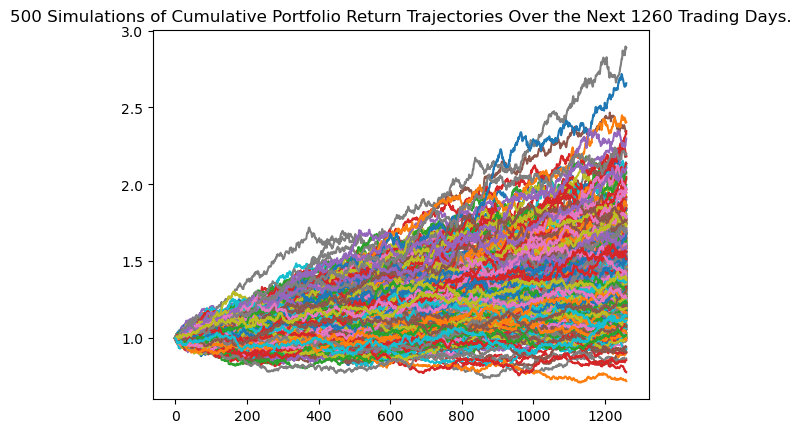

In [24]:
# Plot simulation outcomes
line_plot = MC_30year.plot_simulation()

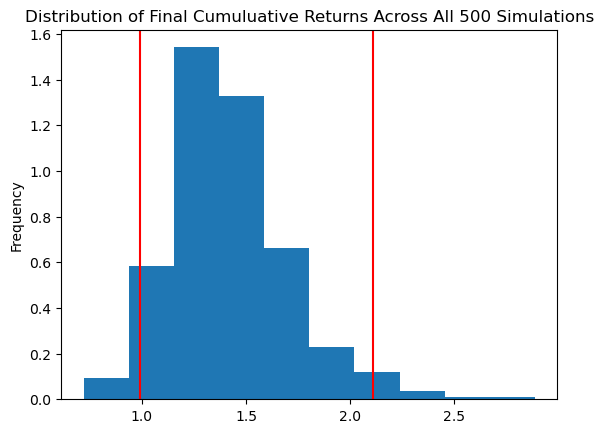

In [25]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30year.plot_distribution()

In [26]:
###Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

### Retirement Analysis

In [27]:
# Fetch summary statistics from the Monte Carlo simulation results
tb1 = MC_30year.summarize_cumulative_return()

# Print summary statistics
print(tb1)

count           500.000000
mean              1.420430
std               0.283965
min               0.721051
25%               1.228764
50%               1.377482
75%               1.565375
max               2.887904
95% CI Lower      0.989016
95% CI Upper      2.108346
Name: 1260, dtype: float64


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [28]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tb1[8]*1000.2)
ci_upper = round(tb1[9]*1000.2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $989 and $2109


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [29]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tb1[8]*1000.2)
ci_upper = round(tb1[9]*1000.2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $989 and $2109


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year = MCSimulation(
    portfolio_data=df_ticker,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [31]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 120.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 130.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 140.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 150.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 180.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 190.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 200.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 210.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 240.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 250.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 280.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 290.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 300.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 330.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 340.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 350.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 360.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 370.
Running Monte Carlo simulation number 380.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 390.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 400.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 410.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 420.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 430.
Running Monte Carlo simulation number 440.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 450.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 460.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 470.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 480.
Running Monte Carlo simulation number 490.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999583,0.999783,1.000638,1.015019,0.997835,1.000912,0.996233,0.996978,1.002176,1.003231,...,0.999986,0.995336,0.996498,1.001776,1.001646,0.999342,0.998547,0.996747,1.005203,1.009476
2,0.998884,1.013557,0.999451,1.018464,0.998033,1.004812,1.003994,0.998753,0.998273,1.010409,...,0.995942,0.990207,0.985992,0.998759,1.001082,1.004801,0.997257,1.000012,1.007863,1.010448
3,1.002442,1.011022,1.000971,1.021836,0.991423,1.005881,1.000704,1.018064,1.005511,1.017127,...,0.999802,0.996401,0.984595,0.996730,0.999245,1.002489,1.005480,1.000765,1.015922,1.004191
4,1.005129,1.009402,0.996380,1.016764,0.990720,0.997925,0.999378,1.017783,1.012316,1.025718,...,1.003341,0.992567,0.987166,0.997517,1.002648,1.003989,1.011976,0.999691,1.016802,1.006095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.091701,1.724562,1.227316,2.289293,1.182526,1.491596,0.982167,1.140144,1.413134,1.005862,...,1.875154,1.169422,1.307554,1.305504,1.680730,1.212508,1.768329,1.434309,1.519969,1.269563
1257,1.099351,1.733291,1.223840,2.316239,1.179519,1.489547,0.989820,1.141701,1.400778,1.007272,...,1.870550,1.159569,1.309477,1.306074,1.676560,1.214997,1.762079,1.436945,1.518808,1.265221
1258,1.093987,1.732862,1.236853,2.322507,1.183365,1.489838,0.990534,1.151733,1.406534,1.006352,...,1.868320,1.155914,1.301477,1.309925,1.684748,1.218660,1.750262,1.434668,1.515859,1.264487
1259,1.085280,1.729777,1.240095,2.327151,1.188384,1.493262,0.982940,1.153591,1.422304,1.008412,...,1.875486,1.156764,1.305572,1.319678,1.680887,1.217880,1.762706,1.434133,1.538243,1.267574


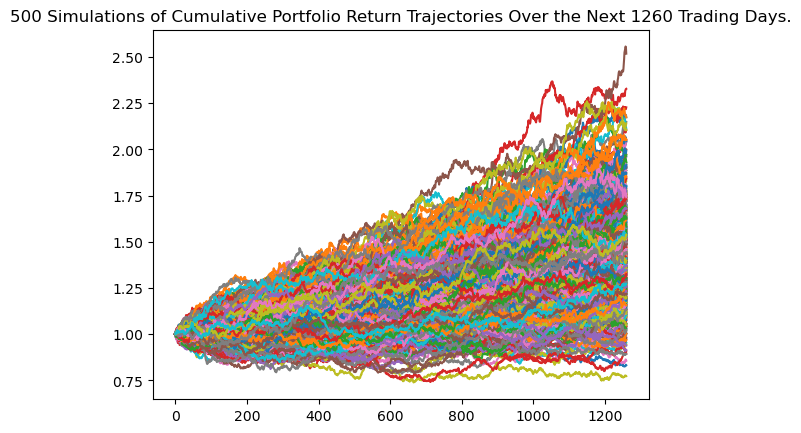

In [32]:
# Plot simulation outcomes
line_plot = MC_5year.plot_simulation()

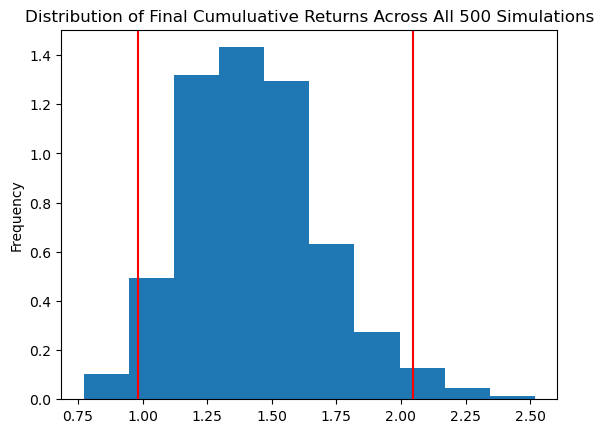

In [33]:
# Plot probability distribution and confidence intervals
dist_plt = MC_5year.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tb2 = MC_30year.summarize_cumulative_return()

# Print summary statistics
print(tb2)

count           500.000000
mean              1.420430
std               0.283965
min               0.721051
25%               1.228764
50%               1.377482
75%               1.565375
max               2.887904
95% CI Lower      0.989016
95% CI Upper      2.108346
Name: 1260, dtype: float64


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [35]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tb1[8]*1000.2)
ci_upper_five = round(tb1[9]*1000.2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $989 and $2109


### Ten Years Retirement Option

In [36]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year = MCSimulation(
    portfolio_data=df_ticker,
    weights = [.60, .40],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [37]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 120.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 130.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 140.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 170.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 180.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 190.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 200.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 230.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 260.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 270.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 280.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 310.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 320.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 330.
Running Monte Carlo simulation number 340.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 350.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 360.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 370.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 380.
Running Monte Carlo simulation number 390.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 400.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 410.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 420.
Running Monte Carlo simulation number 430.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 440.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 450.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 460.
Running Monte Carlo simulation number 470.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 480.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

Running Monte Carlo simulation number 490.


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:117: PerformanceWarning: DataFrame is hi

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997787,0.996814,1.009718,1.004284,1.001795,1.004782,0.997620,0.995109,1.008395,0.999509,...,1.004651,0.996026,1.007101,1.002522,1.002988,1.011744,1.000358,1.001428,0.996459,0.999325
2,1.002357,0.995594,1.011885,1.009203,0.999310,1.011758,0.999269,0.997761,1.006390,1.005487,...,1.001490,1.004744,1.010442,0.999369,1.004859,1.013194,1.005360,0.997513,1.001803,0.996911
3,1.000266,0.985600,1.002282,1.020433,1.000038,1.006389,0.996597,0.997100,1.012094,1.006777,...,1.002364,1.017072,0.999992,1.002893,1.009726,1.014066,1.012635,1.000633,1.009425,1.001471
4,1.008205,0.981758,1.005180,1.017307,0.989107,1.011611,0.995384,0.998295,1.009567,1.010827,...,1.004555,1.020719,0.999654,1.003001,1.017393,1.015410,1.015944,1.001552,1.014072,0.996747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.235758,1.032391,1.080058,1.804191,1.330849,1.685059,1.519586,1.464734,1.620225,1.467579,...,1.384847,1.460074,1.531620,1.358662,1.423134,1.279247,2.058382,1.377330,1.620782,1.274417
1257,1.238799,1.025292,1.079718,1.793673,1.332241,1.676547,1.528723,1.473637,1.613319,1.471454,...,1.396563,1.454876,1.543850,1.363589,1.408521,1.271509,2.077908,1.369593,1.619290,1.267118
1258,1.245462,1.025015,1.088787,1.802296,1.328942,1.664696,1.537036,1.465778,1.624749,1.475091,...,1.392029,1.458223,1.538198,1.371814,1.409955,1.277217,2.076922,1.377692,1.618108,1.272239
1259,1.246067,1.033595,1.095111,1.799769,1.329241,1.635255,1.535823,1.477182,1.633461,1.479611,...,1.383395,1.453318,1.546814,1.380027,1.409154,1.271667,2.087769,1.384899,1.619833,1.271222


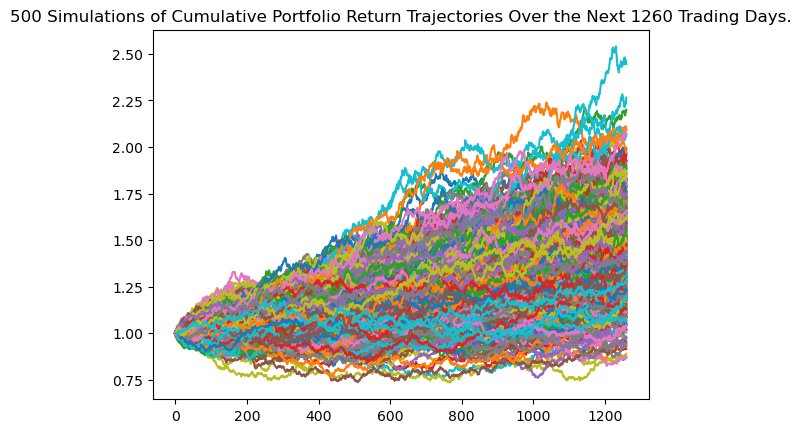

In [38]:
# Plot simulation outcomes
line_plot = MC_10year.plot_simulation()

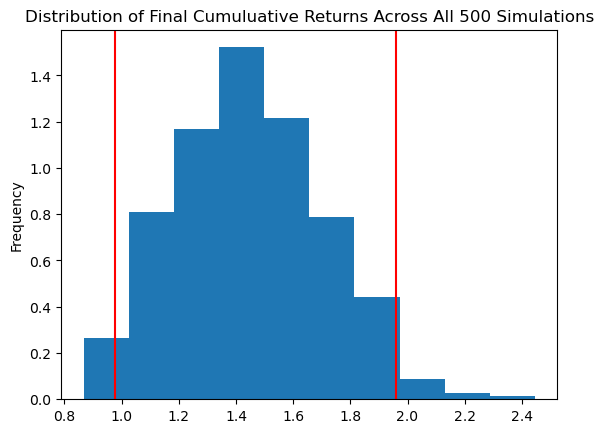

In [39]:
# Plot probability distribution and confidence intervals
dist_plt = MC_10year.plot_distribution()

In [41]:
# Fetch summary statistics from the Monte Carlo simulation results
tb3 = MC_10year.summarize_cumulative_return()

# Print summary statistics
print(tb3)

count           500.000000
mean              1.444008
std               0.260181
min               0.868075
25%               1.252299
50%               1.434083
75%               1.611683
max               2.445307
95% CI Lower      0.975313
95% CI Upper      1.958809
Name: 1260, dtype: float64


c:\Users\chris\Desktop\Bootcamp\HW\Module 5\Module-5-API-Challenge\MCForecastTools.py:172: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return metrics.append(ci_series)


In [42]:
# Set initial investment
initial_investment = 20000 * 3

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tb3[8]*1000.2)
ci_upper_five = round(tb3[9]*1000.2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $976 and $1959
